<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px">
<b>CST Cluster-Galaxy Correlation Functions</b> <br>
Contact author(s): <i>James Annis</i> <br>
Last verified to run: <i>2023-03-10</i> <br>
LSST Science Pipelines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

In [3]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)
# While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing

ModuleNotFoundError: No module named 'pycodestyle_magic'

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** Compute cluster-red-galaxy correlation function.

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

- seaborn
- astropy.units
- astropy.cosmology
- pandas
- treecorr
- dark_emulator

**Credit:**


**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction


_Cite or link to any external information or documentation, and cross-reference to other notebooks._

Formally, this notebook illustrates how to take a cluster catalog and compute the cluster-galaxy correlation function for a well defined set of galaxies.

Importantly, the notebook also discusses interacting with the RSP notebook aspect. Clearly,
you have decided to come to the RSP and stay awhile. Nice- that fits our model of keeping the computation near the data. But if you come from a data science or cosmology tradition, the notebook aspect may not work like you expect. The early stages of deployment of the RSP imposes some constraints.

### 1.1 How RSP Notebook Aspect differs

If you are used to the environment in, say, NERSC's JupyterHub notebooks, you will find the RSP notebooks envirnment a bit different. There is much more Rubin LSST data specific code and functionality available, of course. That is the purpose of most of our tutorial notebooks, to show you the power and flexibility of these codes. But setting up a functional work environment will be different.

#### 1.1.1 IDE Front End Connections to the Notebook

For example, you may be used to using VSCode or DataSpell as a front end to JupyterHub notebooks, like ours. Typically these connect to the JupyterHub using a URL and an authentication token. Once connected, locally working on notebooks with the increased capabilities of VSCode or DataSpell can usefully increase your ability to write the codes that implement your science. In our case, our authentication methodology makes it difficult to allow these connections, and as of this writing (March 2023) they are impossible.

#### 1.1.2 Conda Environments for Users 

##### 1.1.2.1 Mamba, not Conda

First, you want to use mamba, not conda. Just replace the word "conda" with "mamba" in all interactions with conda environments. Trust me. The biggest improvement comes in the time it takes to solve conda enviroment. Mamba is **much faster**. To be fair, this is a difficult problem, but mamba handles it speedily.

You will need to do a "mamba init" in the command line interface. You do use the command line interface, yes? (Once, only. If you want to stick with conda, you'll have to do a "conda init").

##### 1.1.2.2 The installed environment

If you do a "mamba env list" you will see that you have a base conda environment. As of March 2023, this is the result
```
$ mamba env list
# conda environments:
#
base                  *  /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0
```
This is a very extensive conda environment, with on order of 800 separate packages. 

This environment is read only, so you cannot add packages. We generally advise using "pip installs" to add software, but this has known limitations. We'll explore a different approach here.

If by chance you have done "pip installs", and in an attempt to clean these up, you deleted " \~/.local" to remove them (as pip installs to " \~/.local/lib" when global areas are read-only) , you have also broken your notebook interface. At a minimum, you'll have to create the dirs " \~/.lib/share/jupyter/notebook_secret" and " \~/.lib/share/jupyter/runtime" before your notebooks will open again.

##### 1.1.2.3 Conda user environments- the non-optimal approach

It isn't a good idea to do clone the installed environment to your local area, via something like
```
mamba create --name JTA-base --clone base  # no, this is a bad idea!
```
This results in a 15 GB install, and will lack some Rubin specific packages. When I did it, the result was
```
The following packages cannot be cloned out of the root environment:
 - conda-forge/linux-64::conda-22.11.1-py310hff52083_1
 - conda-forge/linux-64::mamba-1.3.1-py310h51d5547_1
 - conda-forge/linux-64::rubin-env-nosysroot-5.1.0-py310he60e456_6
 - conda-forge/linux-64::rubin-env-rsp-5.1.0-hff52083_6
 - conda-forge/linux-64::rubin-env-5.1.0-py310hff52083_6
 ```
 Those will be lacking, and the environment is likely to unweildy to be of use when you are trying to put together an environment for your particular science analysis.
 
##### 1.1.2.4 Conda user environments- a better approach 

A better idea is to use a local conda environment and set it up as a named kernel. Then one can select that kernel for a notebook. Or, as we will try here. We will use the LSST kernel for part of the notebook, then switch kernels to use our installed software


### 1.1 Package Imports

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [1]:
# general python packages
import numpy as np  # vector math package, fundamental to efficient scientific computing
import pandas as pd # dataframe package, efficient table manipulations
import matplotlib.pyplot as plt # base plotting package
import seaborn as sns # plotting package layered on top of Matplotlib, better aesthetics and better plots
import astropy.units as u # A way to attach units to variables

# data file interface
import fitsio  # If one needs to read a fits file. There are many fits readers

# cosmology packages
from astropy.cosmology import FlatLambdaCDM  # We need the cosmology to compute, for example, Mpc from degrees
import treecorr as tc   # community standard correlation function computation package
from dark_emulator import model_hod # Cosmology dependent correlation function predictions. See <a href="https://darkquestcosmology.github.io">Dark Quest website</a> and <a href="https://dark-emulator.readthedocs.io/en/latest/"> dark emulator documentation</a>

# Fantastic- it gets rid of the extensive debugging messages
# plt.set_loglevel("info")

# LSST package for TAP queries
# from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
# import lsst.daf.butler as dafButler

# LSST package for image display
# import lsst.afw.display as afwDisplay

plt.style.use('tableau-colorblind10')

### 1.2 Define Functions and Parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

#### 1.2.1 Uploaded Data Location

In [2]:
data_path = '/Users/annis/Code/dark_emulator/anmol/data/' # JTA laptop   to be replaced

For now we use DES redmagic galaxies and ACT clusters

In [3]:
redmagic_filename = 'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_highdens.fit'
randoms_filename = 'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_highdens_randoms.fit'

# these have been turned into pickles
redmagic_filename = 'redmagic_catalog_galaxies.pkl'
randoms_filename = 'redmagic_catalog_randoms.pkl'

act_filename = 'act_catalog_clusters.pkl'

#### 1.2.2 Control parameters

In [7]:
# based on DES Y3 g-g and g-shear cosmology papers, the redshift bins for the redmagic galaxies
zbins = [ [0.15,0.35], [0.35, 0.5], [0.5, 0.65], [0.65, 0.80]  ]

# create redmagic pickles
create_rm_data_vectors = False
#create_rm_data_vectors = True

# create act pickles
create_act_pickles = False
#create_act_pickles = True

create_cl_data_vectors = False

#### 1.2.3 Galaxy catalogs preparation

##### 1.2.3.1 Galaxy data loading function

In [5]:
def load_redmagic(filename, ftype="galaxy"):

    '''
    This function reads the pickled redmagic galaxy and random
    data pandas dataframes
    '''

    df = pd.read_pickle(filename)
    return df

##### 1.2.3.2 Build galaxy autocorrelation datavectors

In [8]:
def create_redmagic_datavector(zbins) :
    df_gal = load_redmagic(data_path+redmagic_filename, ftype='galaxy')
    df_rand = load_redmagic(data_path+randoms_filename, ftype='randoms')

    for zbin in zbins :
        zavg = (zbin[0]+zbin[1])/2.
        xi,varxi,theta = xi_in_bin(df_gal, df_rand, zbin=zbin)
        df = pd.DataFrame({"wp":xi, "varwp":varxi, "theta":theta})
        filename = data_path + "wp_redmagic_{:3.2f}.pkl".format(zavg)
        print("writing to {:s}".format(filename))
        df.to_pickle(filename)



##### 1.2.3.3 Read galaxy autocorrelation datavectors

In [9]:
def read_redmagic_datavector(zbins) :
    wp_redmagic = dict()
    for zbin in zbins :
        zavg = (zbin[0]+zbin[1])/2.
        zavg = "{:3.2f}".format(zavg)
        filename = data_path + "wp_redmagic_{}.pkl".format(zavg)
        print("reading {:s}".format(filename))
        df = pd.read_pickle(filename)
        # convert theta from degrees to arcminutes
        df["theta"] = df["theta"]*60.
        wp_redmagic[zavg] = df
    return wp_redmagic



#### 1.2.4 Cluster Catalog

For now, let's use the ACT cluster catalog. This is a SZ selected cluster sample.

ACT DR5 SZ cluster catalogs
link: https://lambda.gsfc.nasa.gov/product/act/actpol_dr5_szcluster_catalog_info.cfm

Download "DR5 Cluster Catalog" and "DR5 Survey Mask".

The paper is many places, but https://lss.fnal.gov/archive/2020/pub/fermilab-pub-20-458-ae.pdf

##### 1.2.4.1 Build cluster catalog pickle

In [15]:
def create_act(filename, ftype = 'cluster'):

    '''
    This function converts the redmagic galaxy and random
    data into pandas dataframe for easy application of
    various cuts
    '''

    if ftype == 'cluster':
        columns = ['ra', 'dec', 'z', 'Y',
                   'DESY3', 'match_rm', 'lam',
                   'Camira', 'match_cam','n_mem',
                   'snr']
        f = fitsio.FITS(filename)
        df = pd.DataFrame(np.stack((f[1]['raDeg'][:], f[1]['decDeg'][:], f[1]['redshift'][:], f[1]['y_c'][:],
                                    f[1]['footprint_DESY3'][:],  f[1]['RMDESY3'][:], f[1]['RMDESY3_LAMBDA_CHISQ'][:],
                                    f[1]['footprint_HSCs19a'][:],  f[1]['CAMIRA'][:], f[1]['CAMIRA_N_mem'][:],
                                    f[1]['fixed_SNR'][:]
                                    ), axis=-1), columns = columns)
        print("writing " + data_path+"act_catalog_clusters.pkl")
        df.to_pickle(data_path+"act_catalog_clusters.pkl")


##### 1.2.4.2 Load ACT catalog pickle and make pure sample

In [16]:
# Tae (Jan 13, 2022 DES Cl-Cos meeting) gives 0.15 < z < 0.7 and fixed_snr > 5.5 as a pure sample of ACT clusters
# We'll adopt the fixed_snr cut
def load_act_des(filename) :
    df = pd.read_pickle(filename)
    df = df[ (df['snr'] > 5.5) & (df['match_rm']== 1)]
    return df

#### 1.2.5 Functions for auto- and cross-correlation functions

We define
- xi_in_bin as the auto-correlation for a galaxy catalog in a dataframe
- cross_xi_in_bin as the cross-correlation of the galaxy catalog dataframe and a cluster catalog dataframe

In [4]:
def xi_in_bin(df_gal, df_rand, zbin=[]):

    '''
    This function calls the treecorr library to compute
    correlation functions in a given bin using a galaxy
    and a random sample.
    '''

    zmin = zbin[0]
    zmax = zbin[1]

    df_gal = df_gal[(df_gal['z']>zmin)&(df_gal['z']<zmax)]
    df_rand = df_rand[(df_rand['z']>zmin)&(df_rand['z']<zmax)]

    galaxies = tc.Catalog(ra=df_gal['ra'][:], dec=df_gal['dec'][:], ra_units='degrees', dec_units='degrees')
    randoms = tc.Catalog(ra=df_rand['ra'][:], dec=df_rand['dec'][:], ra_units='degrees', dec_units='degrees')

    print('-------------------------------------------------------------------')
    print('computing ' + str(len(df_gal)) + ' galaxies and '
          + str(len(df_rand)) + ' randoms in zbin [' + str(zmin) + ',' + str(zmax) + ']')
    print('-------------------------------------------------------------------')

    #theta_min, theta_max = do_cosmology(zbin,np.asarray([0.1, 200.]), 'angle')
    theta_min, theta_max = .3/60., 300./60.
    nbins = 25

    gg = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    gr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    rr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')

    gg.process(galaxies, num_threads=5)
    gr.process(galaxies, randoms, num_threads=5)
    rr.process(randoms, num_threads=5)

    xi,varxi = gg.calculateXi(rr,gr)
    theta = np.exp(gg.logr)

    return xi, varxi, theta

def cross_xi_in_bin(df_cl, df_gal, df_rand, zbin=[], lbin=[], lname="lam"):

    '''
    This function calls the treecorr library to compute
    correlation functions in a given bin using a galaxy
    and a random sample.
    '''

    zmin = zbin[0]
    zmax = zbin[1]
    lmin = lbin[0]
    lmax = lbin[1]

    df_cl = df_cl[(df_cl['z']>=zmin)&(df_cl['z']<zmax) & (df_cl[lname]>=lmin) & (df_cl[lname]<lmax)]
    df_gal = df_gal[(df_gal['z']>=zmin)&(df_gal['z']<zmax)]
    df_rand = df_rand[(df_rand['z']>=zmin)&(df_rand['z']<zmax)]

    print('--------------------------------------------------------------------------------------------------')
    print('computing ' + str(len(df_cl)) + ' clusters in ' + lname +' [' + str(lmin) + ',' + str(lmax)
          + '] and ' + str(len(df_gal)) + ' galaxies and '
          + str(len(df_rand)) + ' randoms in zbin [' + str(zmin) + ',' + str(zmax) + ']')
    print('--------------------------------------------------------------------------------------------------')

    clusters = tc.Catalog(ra=df_cl['ra'][:], dec=df_cl['dec'][:], ra_units='degrees', dec_units='degrees')
    galaxies = tc.Catalog(ra=df_gal['ra'][:], dec=df_gal['dec'][:], ra_units='degrees', dec_units='degrees')
    randoms = tc.Catalog(ra=df_rand['ra'][:], dec=df_rand['dec'][:], ra_units='degrees', dec_units='degrees')

    #theta_min, theta_max = do_cosmology(zbin,np.asarray([0.1, 200.]), 'angle')
    theta_min, theta_max = .3/60., 300./60.
    nbins = 25

    gg = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    gr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    rr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')

    gg.process(galaxies, clusters, num_threads=5)
    gr.process(galaxies, randoms, num_threads=5)
    rr.process(randoms, num_threads=5)

    xi,varxi = gg.calculateXi(rr,gr)
    theta = np.exp(gg.logr)

    return xi, varxi, thet

## 2. Galaxy-galaxy correlation function

### 2.1 Read, creating if necessary, the galaxy data vector

In [10]:
if create_rm_data_vectors:
    create_redmagic_datavector(zbins)
wp_redmagic = read_redmagic_datavector(zbins)

reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.25.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.42.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.57.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.73.pkl


### 2.2 Plot the galaxy-galaxy correlation function

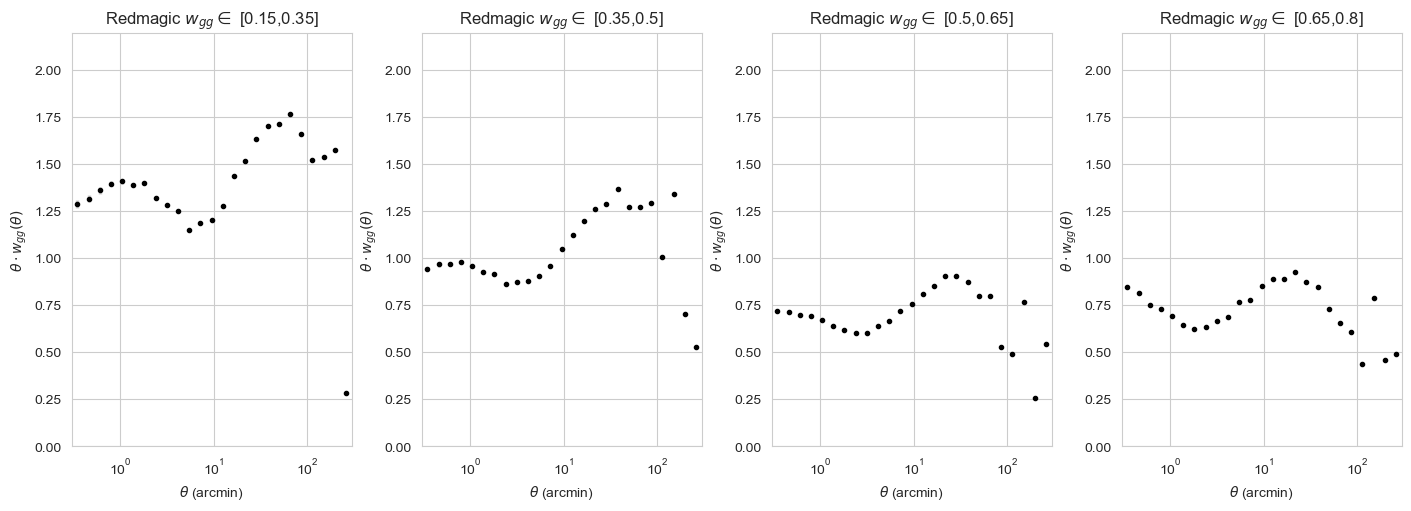

In [14]:
def plot_wp(wp_redmagic, zbins) :

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14, 5), constrained_layout=True)

    for i in range(0,len(zbins)) :
        zbin = zbins[i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)

        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta

        ax[i].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                       elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
        ax[i].set_xlim(0.3,300)
        ax[i].set_ylim(0,2.2)
        ax[i].set_xscale('log')
        ax[i].set_title(r'Redmagic $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i].set_xlabel(r'$\theta$ (arcmin)')
        ax[i].set_ylabel(r'$\theta \cdot w_{gg}(\theta)$ ')

plot_wp(wp_redmagic, zbins)

Compare those plots with the plots in, for example, "Dark Energy Survey Year 3 results: Galaxy clustering and systematics treatment for lens galaxy samples", at __[Rodríguez-Monroy, Weaverdyck, Elvin-Poole, Crocce, Carnero Rosell et al.](https://arxiv.org/pdf/2105.13540.pdf)__

## 3. Cluster Catalog

### 3.1 Read, creating if necessary, the cluster data vector

In [17]:
if create_act_pickles:
    create_act(data_path+"DR5_cluster-catalog_v1.1.fits")
df_cl = load_act_des(data_path+act_filename)

### 3.2 Plot the cluster redshift and Y distribution

55 %  below cut


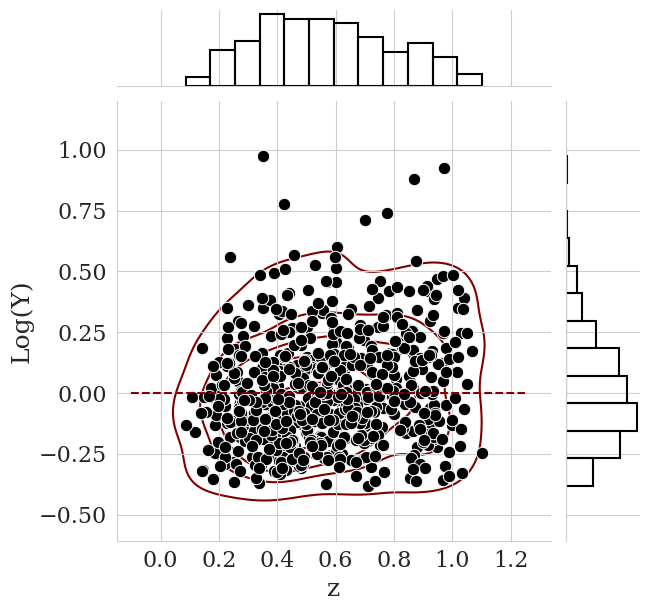

In [37]:

y_cut = 1.0
ax = sns.jointplot( x=df_cl.z, y=np.log10(df_cl.Y) ,  color="k", s=80,
                    marginal_kws=dict(bins=12, fill=False, color="k"), height=6)
ax.plot_joint(sns.kdeplot, color="maroon", zorder=0, levels=6)
ax.ax_joint.plot([-0.1,1.25],[np.log10(y_cut), np.log10(y_cut)], zorder=10, linestyle="dashed", c="maroon")
ax.ax_joint.set_ylabel(r'Log(Y)', fontsize=18, fontfamily="serif")
ax.ax_joint.set_xlabel(r'z', fontsize=18, fontfamily="serif")
for tick in ax.ax_joint.get_xticklabels():
    tick.set_fontfamily("serif"); tick.set_size(16)
for tick in ax.ax_joint.get_yticklabels():
    tick.set_fontfamily("serif"); tick.set_size(16)

#sns.histplot(df_cl, x="z")
x=df_cl[df_cl['Y']<y_cut];
print ( "{:.0f} %  below cut".format(100*x.size/df_cl[df_cl['Y']<1000].size))

### 3.3 Chose the Y bins

We choose three bins in Y_c:
-  bin 0: $Y_c \in $ [0,10]. The whole catalog
-  bin 1: $Y_c \in $ [0,$\phantom{0}$2]. A low mass bin with the bulk of the clusters
-  bin 2: $Y_c \in $ [2,10]. A high  mass bin

In [38]:
y_bins = [ [0,10], [0, 1], [1, 10]  ]

## 4 Cluster-galaxy correlation functions

### 4.1 Function to create cluster-galaxy cross-correlation data vectors

In [39]:
def create_act_datavector(zbins, y_bins, lname="Y") :
    df_cl = load_act_des(data_path+act_filename)
    df_gal = load_redmagic(data_path+redmagic_filename,  ftype='galaxy')
    df_rand = load_redmagic(data_path+randoms_filename, ftype='random')

    for zbin in zbins :
        bin_count = 0
        for y_bin in y_bins :
            zavg = (zbin[0]+zbin[1])/2.
            y_bin_name = bin_count

            xi,varxi,theta = cross_xi_in_bin(df_cl, df_gal, df_rand, zbin=zbin, lbin=y_bin, lname=lname)
            df = pd.DataFrame({"wp":xi, "varwp":varxi, "theta":theta})
            filename = data_path + "wp_act_{:3.2f}_{:1d}.pkl".format(zavg,y_bin_name)
            print("writing to {:s}".format(filename))
            df.to_pickle(filename)
            bin_count += 1



### 4.2 Function to read cluster-Galaxy cross-correlation data vectors


In [40]:
def read_act_datavector(zbins, y_bins) :
    wp_act = dict()
    for zbin in zbins :
        bin_count = 0
        for y_bin in y_bins :
            zavg = (zbin[0]+zbin[1])/2.
            zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count

            filename = data_path + "wp_act_{}_{}.pkl".format(zavg, y_bin_name)
            print("reading {:s}".format(filename))
            df = pd.read_pickle(filename)
            # convert theta from degrees to arcminutes
            df["theta"] = df["theta"]*60.
            wp_act[zavg, y_bin_name] = df
            bin_count += 1
    return wp_act

### 4.3 Read, creating if necessary, the cluster-galaxy cross-correlation data vector

In [41]:
if create_cl_data_vectors:
    create_act_datavector(zbins,y_bins)

wp_act = read_act_datavector(zbins, y_bins)


reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.25_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.25_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.25_2.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.42_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.42_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.42_2.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.57_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.57_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.57_2.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.73_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.73_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.73_2.pkl


### 4.4 Plot the cluster-galaxy cross-correlation data vectors

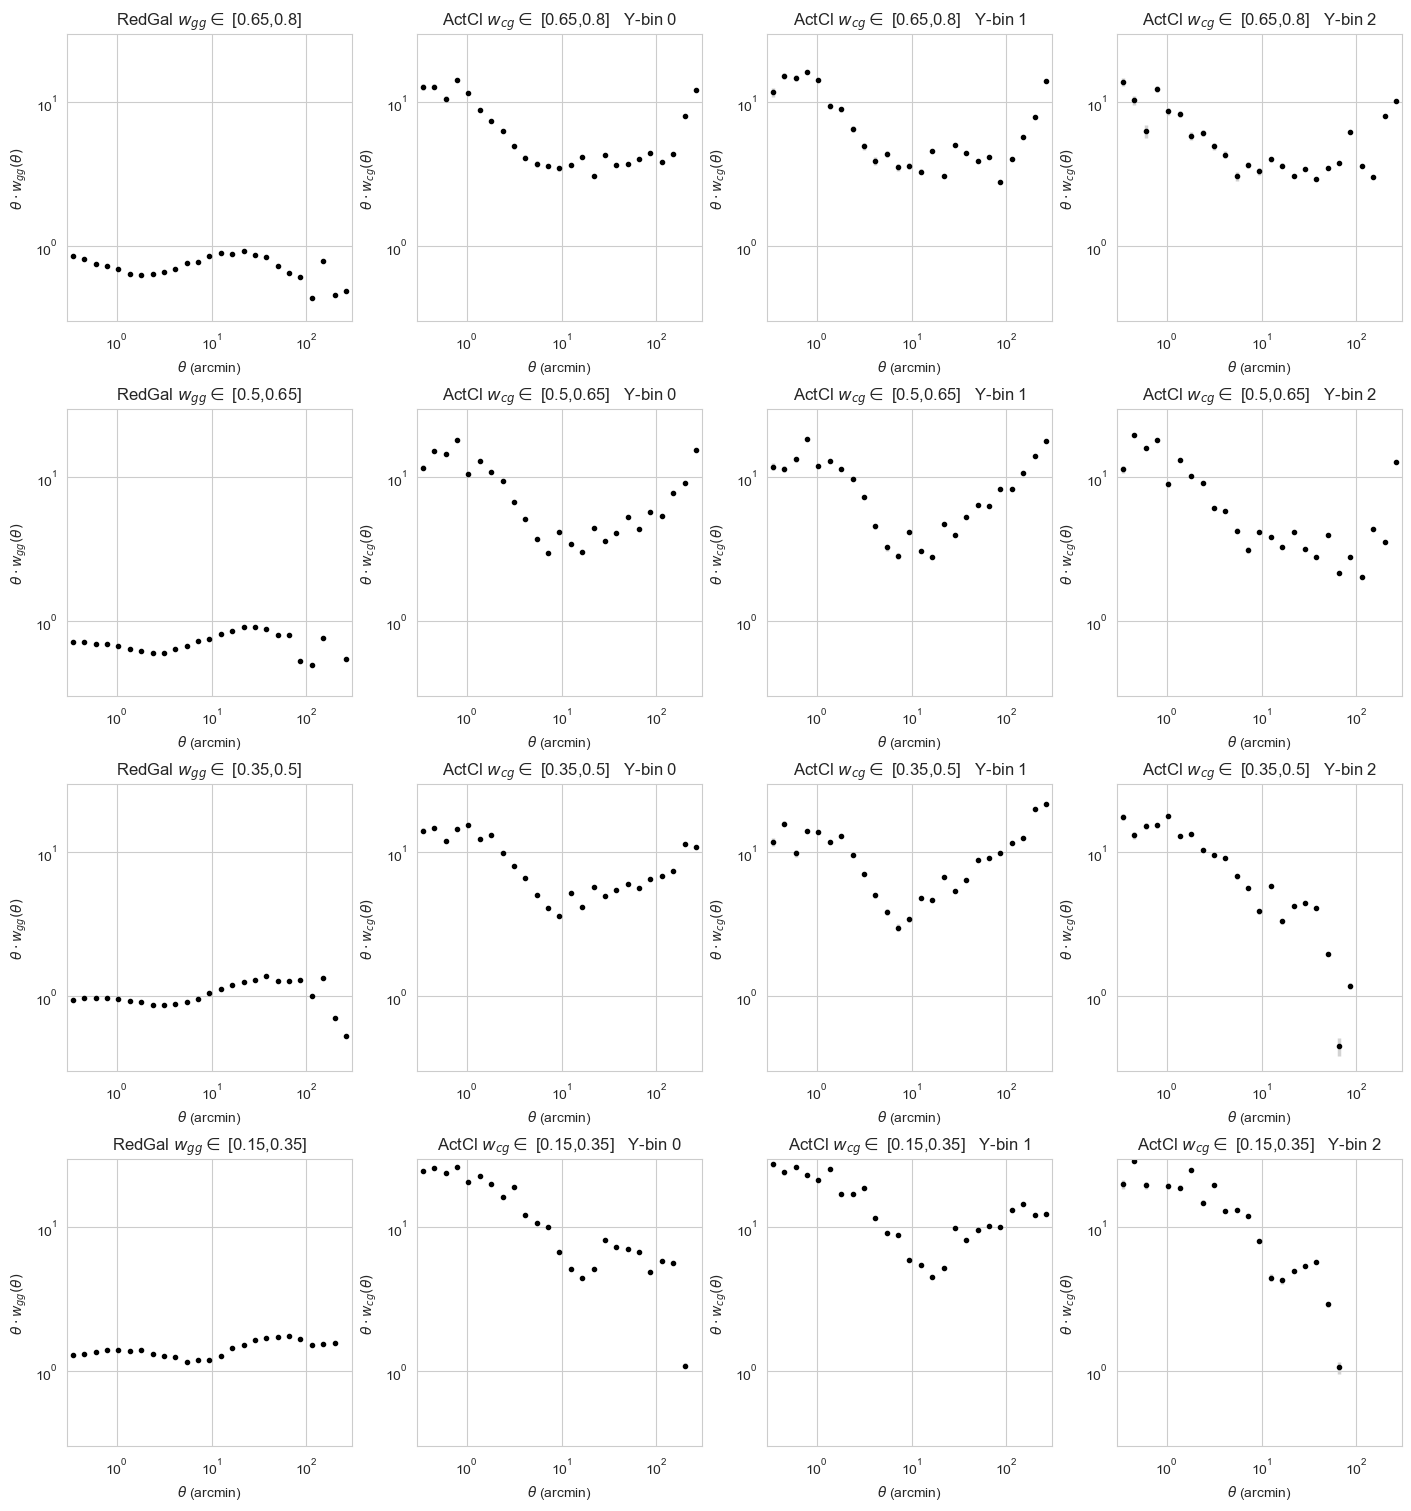

In [43]:
def plot_cross_wp(wp_redmagic, wp_act, zbins, y_bins) :

    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(14, 15), constrained_layout=True)

    for i in range(0,len(zbins)) :
        zbin = zbins[::-1][i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta

        j=0
        ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                          elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
        ax[i][j].set_xlim(0.3,300)
        ax[i][j].set_ylim(0.3,30)
        ax[i][j].set_xscale('log')
        ax[i][j].set_yscale('log')
        ax[i][j].set_title(r'RedGal $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
        ax[i][j].set_ylabel(r'$\theta \cdot w_{gg}(\theta)$ ')

        bin_count = 0
        for j in range(1,len(y_bins)+1) :
            zbin = zbins[::-1][i]
            zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count

            df = wp_act[zavg,y_bin_name]
            wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
            varwp = varwp*theta
            wp    =    wp*theta

            ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                              elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
            ax[i][j].set_xlim(0.3,300)
            ax[i][j].set_ylim(0.3,30)
            ax[i][j].set_xscale('log')
            ax[i][j].set_yscale('log')
            ax[i][j].set_title(r'ActCl $w_{cg} \in$'
                               + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'
                               + "   Y-bin "+ str(y_bin_name) )
            ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
            ax[i][j].set_ylabel(r'$\theta \cdot w_{cg}(\theta)$ ')
            bin_count += 1

plot_cross_wp(wp_redmagic, wp_act, zbins, y_bins)

## 5 Interpret the correlation functions using Dark Emulator

### 5.1 Set the astropy cosmology and the Dark Emulator HOD

In [44]:
hod = model_hod.darkemu_x_hod({'fft_num':8})

cparam = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod.set_cosmology(cparam)
# from G Zacharegkas et. al
#gparam = {"logMmin":12.03, "sigma_sq":0.1156, "logM1": 13.79, "alpha": 1.75, "kappa": 0.0, # HOD parameters
gparam = {"logMmin":12.90, "sigma_sq":0.1156, "logM1": 14.0, "alpha": 1.35, "kappa": 0., # HOD parameters
          "poff":0.2 , "Roff":0.20, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
          "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
          #"sat_dist_type": "NFW", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
          "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)
hod.set_galaxy(gparam)

cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.30)

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


### 5.2 Interpret the galaxy-galaxy correlation function

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib.ticker:vmin 0.3 vmax 300.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 300.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 300.0
DEBUG:matplotlib.ticker:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 300.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-02,

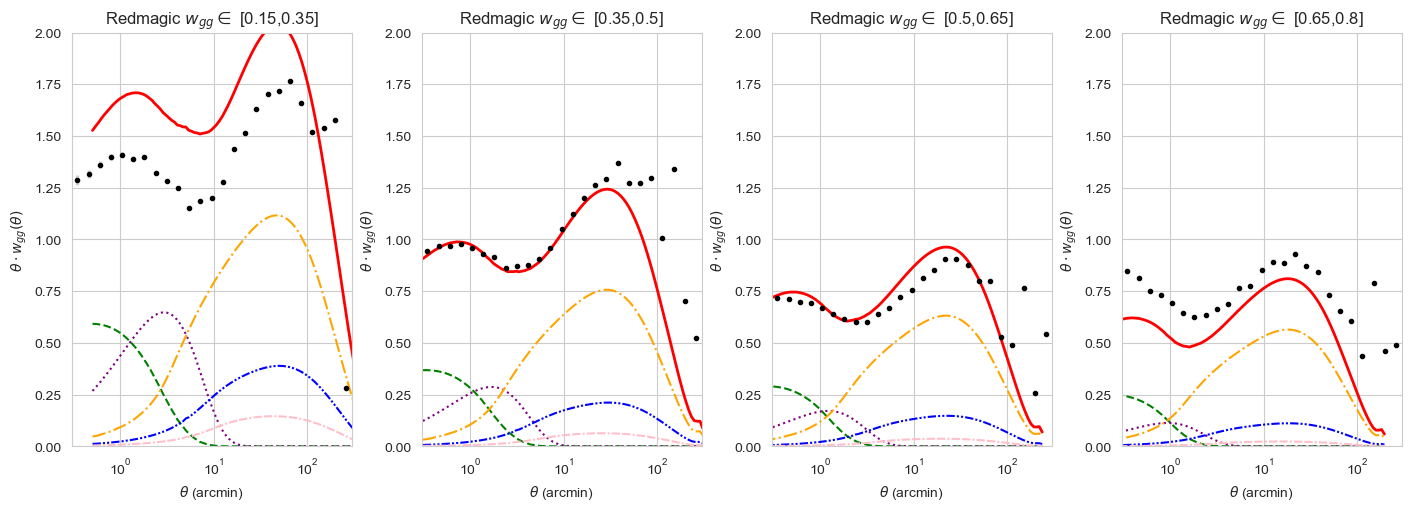

In [46]:
def plot_wp_hod(wp_redmagic, zbins, hod, fudge_factor=450.) :

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14, 5), constrained_layout=True)

    for i in range(0,len(zbins)) :
        zbin = zbins[i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)

        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta

        ax[i].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                       elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))

        zavg = (zbin[0]+zbin[1])/2.
        Dc = cosmo.arcsec_per_kpc_comoving(zavg)
        Dp = cosmo.arcsec_per_kpc_proper(zavg)

        arcmin_per_mpc = Dc.value*(1e3/60.)
        rs = np.logspace(-1,2,100)
        thetas = rs*arcmin_per_mpc/0.68  # Dark Quest emulator gives comoving radii with units of Mpc/h
        thetas2=thetas/fudge_factor
        ax[i].plot(thetas, thetas2*hod.get_wp(rs, zavg), linewidth = 2, color = "r", label = "total")
        ax[i].plot(thetas, thetas2*hod.get_wp_1hcs(rs, zavg), "--", color = "g", label = "1-halo cen-sat")
        ax[i].plot(thetas, thetas2*hod.get_wp_1hss(rs, zavg), ":", color = "purple", label = "1-halo sat-sat")
        ax[i].plot(thetas, thetas2*hod.get_wp_2hcc(rs, zavg), "-.", color = "orange", label = "2-halo cen-cen")
        ax[i].plot(thetas, thetas2*hod.get_wp_2hcs(rs, zavg), dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
        ax[i].plot(thetas, thetas2*hod.get_wp_2hss(rs, zavg), dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")

        ax[i].set_xlim(0.3,300)
        ax[i].set_ylim(0,2.)
        ax[i].set_xscale('log')
        ax[i].set_title(r'Redmagic $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i].set_xlabel(r'$\theta$ (arcmin)')
        ax[i].set_ylabel(r'$\theta \cdot w_{gg}(\theta)$ ')
        #ax[i].legend()

plot_wp_hod(wp_redmagic, zbins, hod)

### 5.3 Interpret the cluster-galaxy correlation function

#### 5.3.1 Set the galaxy HOD

In [47]:
cparam = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod1 = model_hod.darkemu_x_hod({'fft_num':8})
hod1.set_cosmology(cparam)
# from G Zacharegkas et. al
#gparam = {"logMmin":12.03, "sigma_sq":0.1156, "logM1": 13.79, "alpha": 1.75, "kappa": 0.0, # HOD parameters
gparam = {"logMmin":12.90, "sigma_sq":0.1156, "logM1": 14.0, "alpha": 1.35, "kappa": 0., # HOD parameters
          "poff":0.2 , "Roff":0.20, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
          "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
          #"sat_dist_type": "NFW", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
          "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)
hod1.set_galaxy(gparam)

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


#### 5.3.3 Code to set the cluster HOD and the plot

In [50]:
def plot_cross_wp_hod(wp_redmagic, wp_act, zbins, y_bins, hod1, hod2, fudge_factor=450.) :

    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(14, 15), constrained_layout=True)

    for i in range(0,len(zbins)) :
        zbin = zbins[::-1][i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta

        j=0
        ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                          elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))

        zavg = (zbin[0]+zbin[1])/2.
        Dc = cosmo.arcsec_per_kpc_comoving(zavg)
        Dp = cosmo.arcsec_per_kpc_proper(zavg)

        arcmin_per_mpc = Dc.value*(1e3/60.)
        #rs = np.logspace(-1,2,100)
        rs = np.linspace(0.3,10,100)
        thetas = rs*arcmin_per_mpc/0.68  # Dark Quest emulator gives comoving radii with units of Mpc/h
        thetas2=thetas/fudge_factor
        ax[i][j].plot(thetas, thetas2*hod1.get_wp(rs, zavg), linewidth = 2, color = "r", label = "total")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_1hcs(rs, zavg), "--", color = "g", label = "1-halo cen-sat")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_1hss(rs, zavg), ":", color = "purple", label = "1-halo sat-sat")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_2hcc(rs, zavg), "-.", color = "orange", label = "2-halo cen-cen")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_2hcs(rs, zavg), dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_2hss(rs, zavg), dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")

        ax[i][j].set_xlim(0.3,100)
        ax[i][j].set_ylim(0.3,30)
        ax[i][j].set_xscale('log')
        ax[i][j].set_yscale('log')
        ax[i][j].set_title(r'RedGal $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
        ax[i][j].set_ylabel(r'$\theta w_gg(\theta)$ ')

        bin_count = 0
        for j in range(1,len(y_bins)+1) :
            zbin = zbins[::-1][i]
            zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count

            df = wp_act[zavg, y_bin_name]
            wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
            varwp = varwp*theta
            wp    =    wp*theta

            ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                              elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))

            if j == 1:
                logMmin = 14.1
                var = 0.12
                alpha = 1.5
            elif j == 2:
                logMmin = 14.05
                var = 0.12
                alpha = 1.5
            elif j == 3:
                logMmin = 14.15
                var = 0.12
                alpha = 1.5
            logM1 = 14.3
            logM1 = 14.5
            logM1 = 14.7

            gparam = {"logMmin":logMmin, "sigma_sq":var, "logM1": logM1, "alpha": alpha, "kappa": 0., # HOD parameters
                      "poff":0.10 , "Roff":0.25, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
                      "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
                      "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)
            hod2.set_galaxy(gparam)

            #thetas2=thetas2*2.0
            zavg = (zbin[0]+zbin[1])/2.
            one_cen_sat = hod2.get_wp_1hcs(rs, zavg)
            one_sat_sat = hod2.get_wp_1hss(rs, zavg)
            two_cen_cen = hod2.get_wp_2hcc(rs, zavg)
            two_cen_sat = hod2.get_wp_2hcs(rs, zavg)
            two_sat_sat = hod2.get_wp_2hss(rs, zavg)
            total = one_cen_sat + one_sat_sat + two_cen_cen + two_cen_sat + two_sat_sat
            ax[i][j].plot(thetas, thetas2*total, linewidth = 2, color = "r", label = "total")
            ax[i][j].plot(thetas, thetas2*one_cen_sat, "--", color = "g", label = "1-halo cen-sat")
            ax[i][j].plot(thetas, thetas2*one_sat_sat, ":", color = "purple", label = "1-halo sat-sat")
            ax[i][j].plot(thetas, thetas2*two_cen_cen, "-.", color = "orange", label = "2-halo cen-cen")
            ax[i][j].plot(thetas, thetas2*two_cen_sat, dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
            ax[i][j].plot(thetas, thetas2*two_sat_sat, dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")

            #ax[i][j].set_xlim(0.3,300)
            ax[i][j].set_xlim(0.3,100)
            ax[i][j].set_ylim(0.3,30)
            ax[i][j].set_xscale('log')
            ax[i][j].set_yscale('log')
            ax[i][j].set_title(r'ActCl $w_{cg} \in$'
                               + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'
                               + "   Y-bin "+ str(y_bin_name) )
            ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
            ax[i][j].set_ylabel(r'$\theta w_{cg}(\theta)$ ')

            bin_count += 1

#### 5.3.2 Set the cluster HOD and make the plot

In [48]:
hod2 = model_hod.darkemu_x_hod({'fft_num':8})
hod2.set_cosmology(cparam)


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib.ticker:vmin 0.3 vmax 100.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 100.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 100.0
DEBUG:matplotlib.ticker:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 100.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.3 vmax 100.0
D

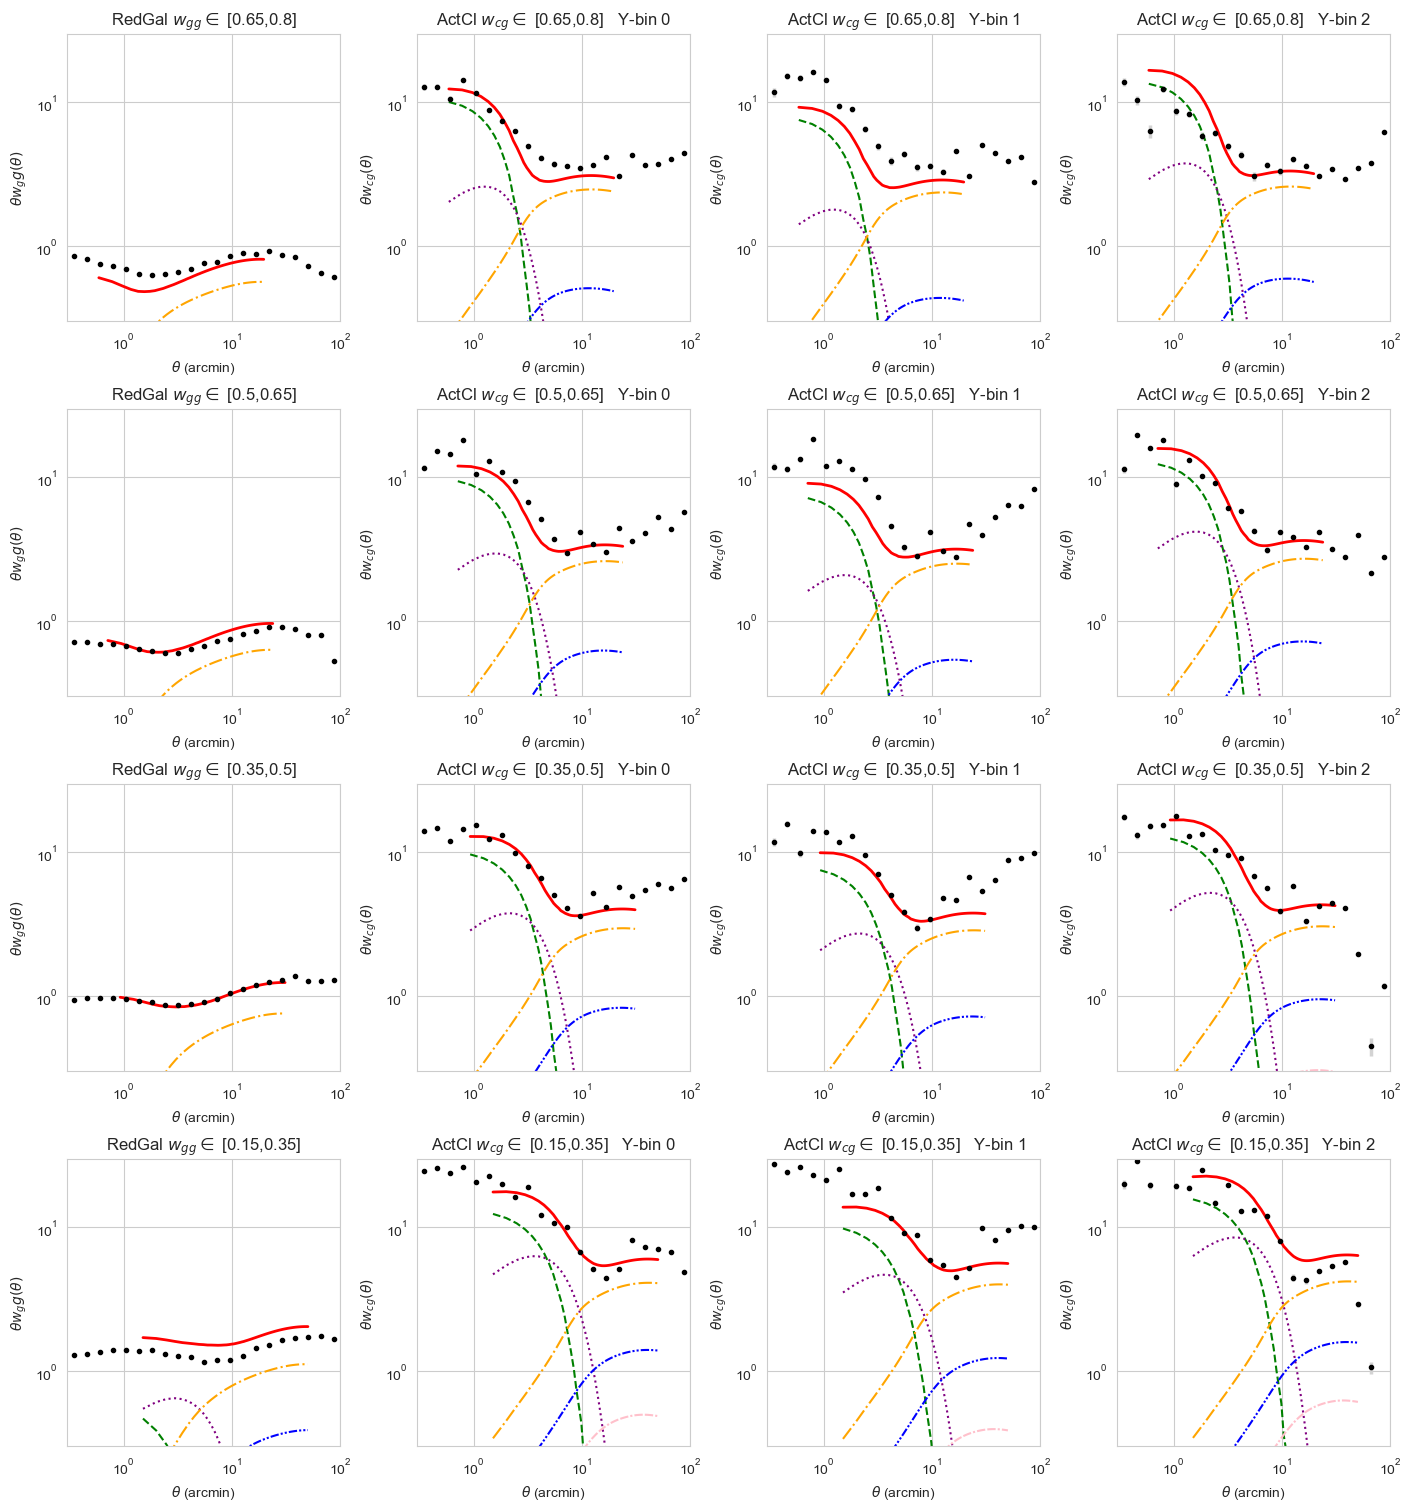

In [51]:
plot_cross_wp_hod(wp_redmagic, wp_act, zbins, y_bins, hod1, hod2)